In [1]:
# Data: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
warnings.filterwarnings('ignore')


### Preliminary Data Analysis

In [2]:
df = pd.read_csv("data.csv", sep=";")
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Missing values: False


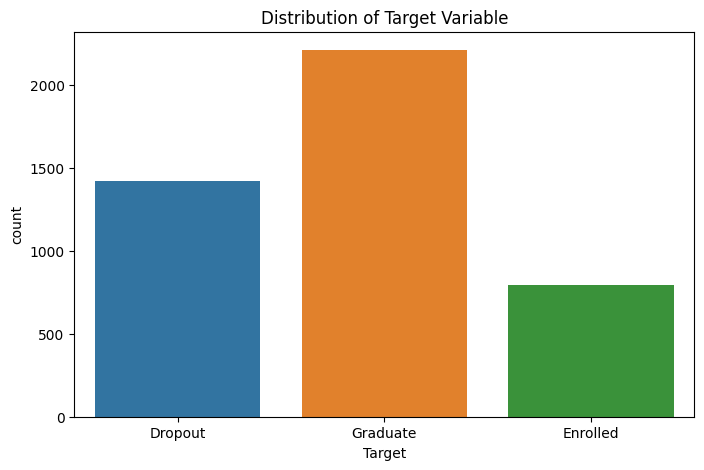

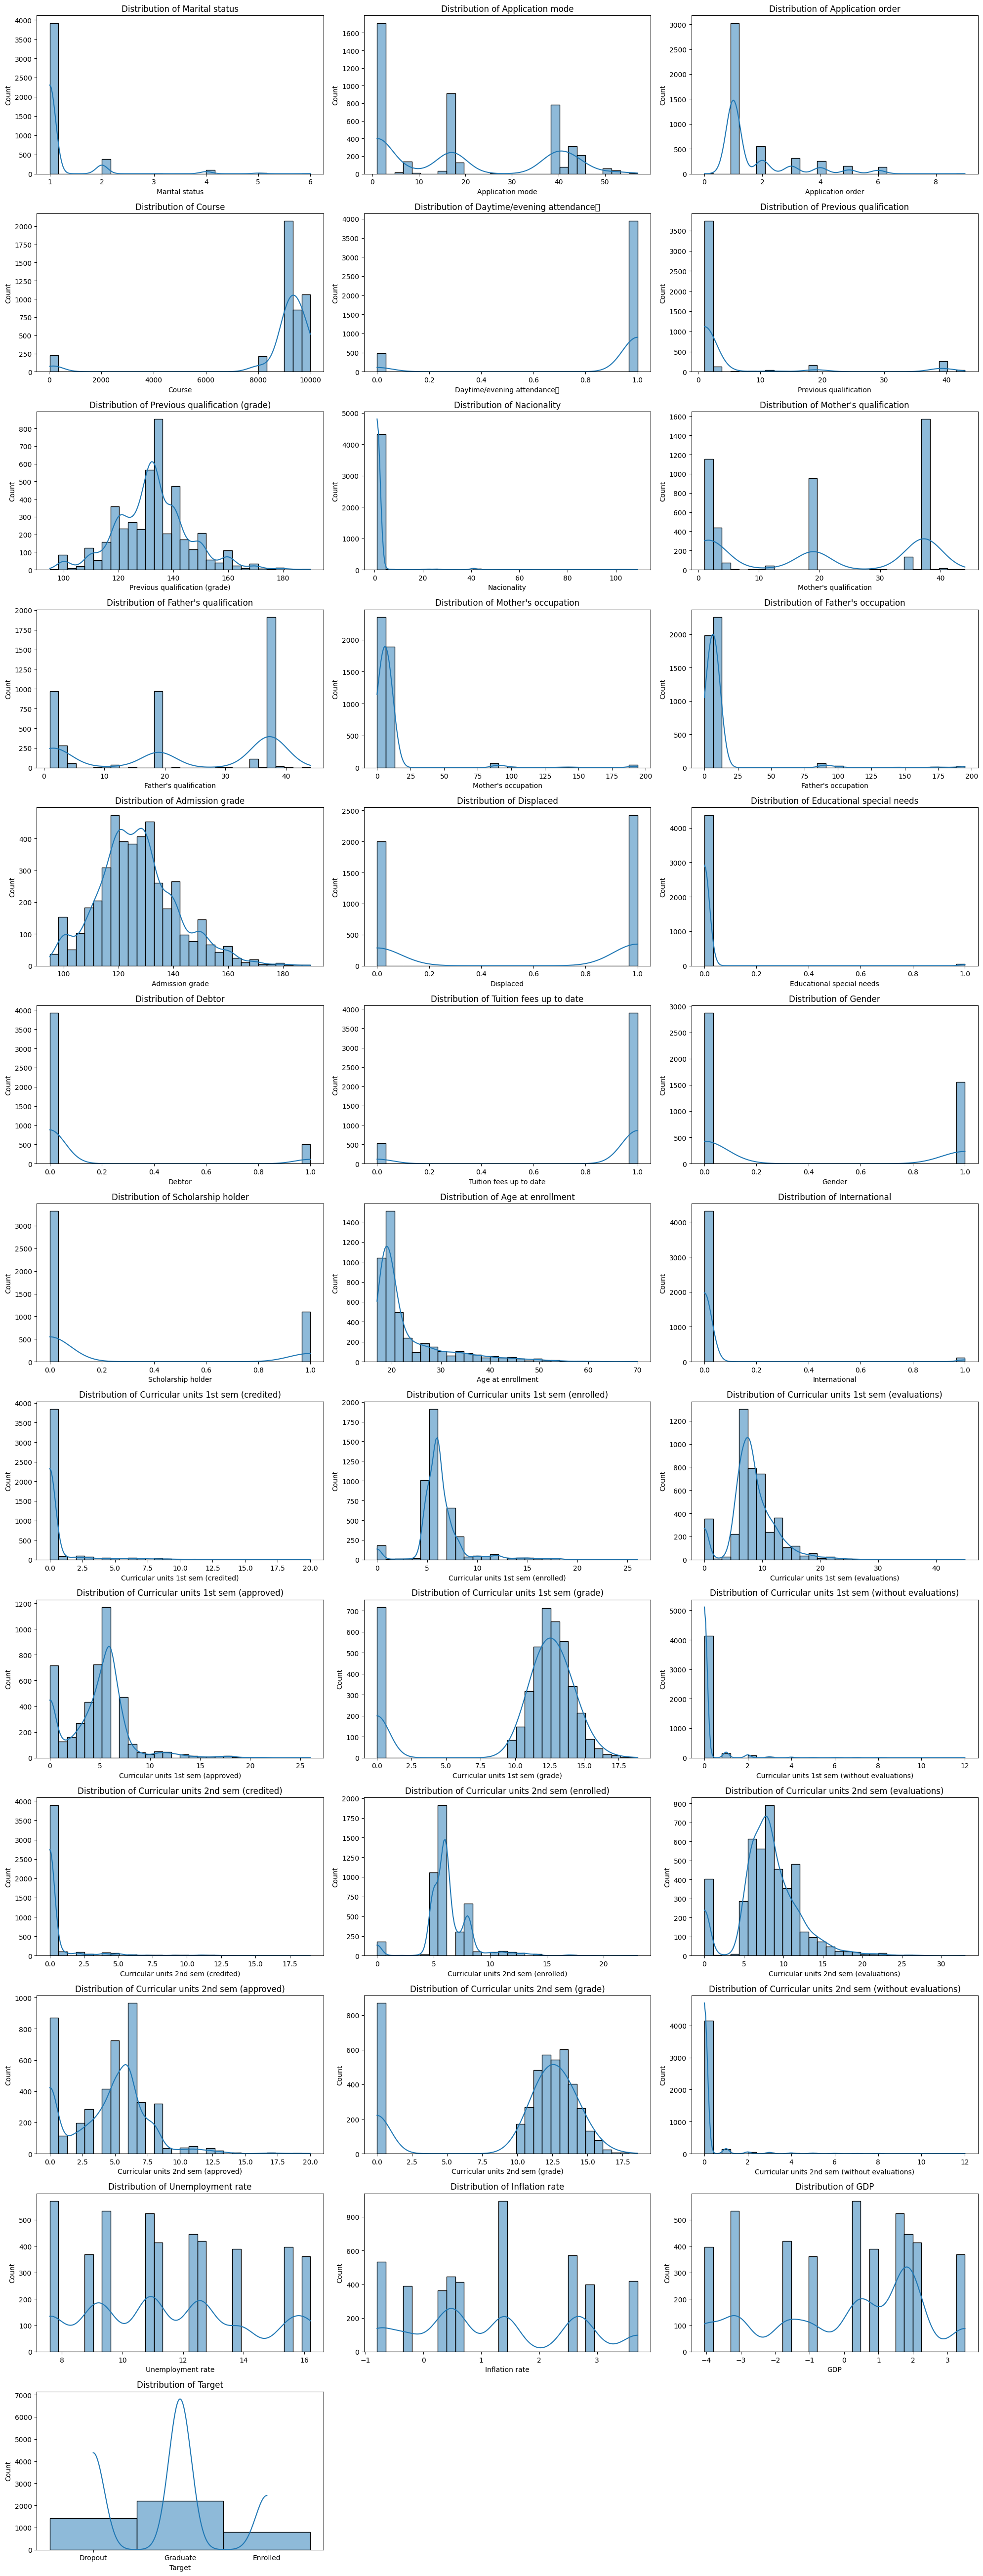

Marital status : 6
Application mode : 18
Application order : 8
Course : 17
Daytime/evening attendance	 : 2
Previous qualification : 17
Previous qualification (grade) : 101
Nacionality : 21
Mother's qualification : 29
Father's qualification : 34
Mother's occupation : 32
Father's occupation : 46
Admission grade : 620
Displaced : 2
Educational special needs : 2
Debtor : 2
Tuition fees up to date : 2
Gender : 2
Scholarship holder : 2
Age at enrollment : 46
International : 2
Curricular units 1st sem (credited) : 21
Curricular units 1st sem (enrolled) : 23
Curricular units 1st sem (evaluations) : 35
Curricular units 1st sem (approved) : 23
Curricular units 1st sem (grade) : 805
Curricular units 1st sem (without evaluations) : 11
Curricular units 2nd sem (credited) : 19
Curricular units 2nd sem (enrolled) : 22
Curricular units 2nd sem (evaluations) : 30
Curricular units 2nd sem (approved) : 20
Curricular units 2nd sem (grade) : 786
Curricular units 2nd sem (without evaluations) : 10
Unemploym

In [3]:
# check for missing values in each column
print("Missing values:", df.isna().sum().any())

# understand distribution of target
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Target")
plt.title("Distribution of Target Variable")
plt.show()

# understand distribution of each column
num_columns = len(df.columns)
plt.figure(figsize=(20, 4 * num_columns))

for i, col in enumerate(df.columns, 1):
    plt.subplot(num_columns, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()

# checking number of unique values in each column
for col in df.columns:
    length = len(df[col].unique())
    print(col,":", length)

### Data Preparation

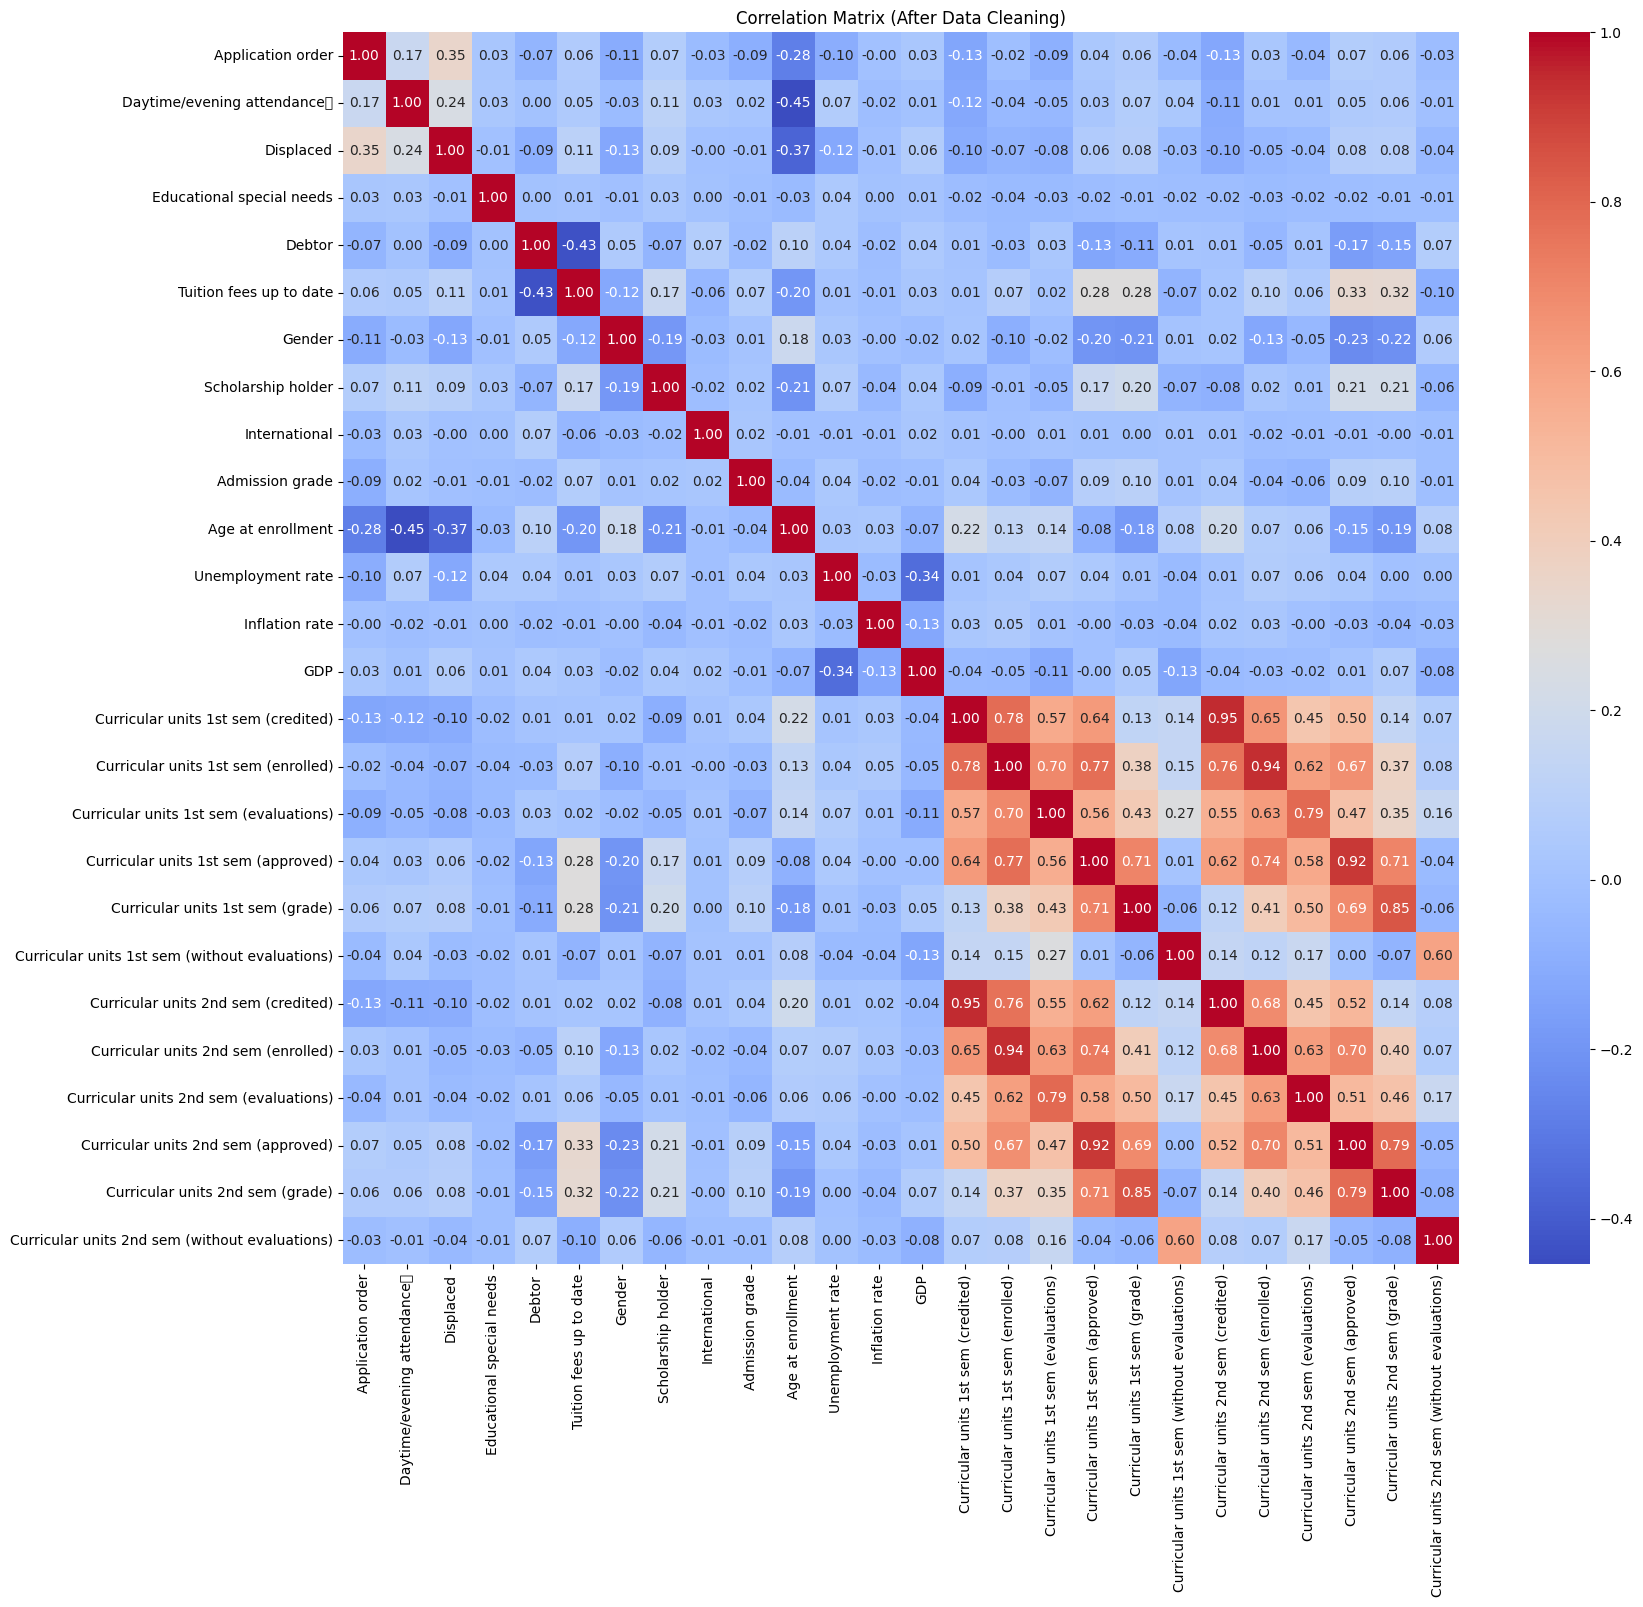

Training and testing data shape (2541, 26) (1089, 26) (2541,) (1089,)
Total Columns:  26


In [4]:
def encode_target(x):
    if x == "Graduate":
        return 1
    elif x == "Dropout":
        return 0
    else:
        return x

# removing rows with target value "Enrolled"
df = df[df['Target'].isin(['Dropout', 'Graduate'])]

prepared_df = pd.DataFrame()

# one hot encoding for categorical variables
one_hot_columns = ["Application mode", "Marital status", "Mother's qualification", 
                   "Father's qualification", "Mother's occupation", 
                   "Father's occupation", "Nacionality", "Course"]

one_hot_encoded_df = pd.DataFrame()
for col in one_hot_columns:
    one_hot_encoded = pd.get_dummies(df[col], prefix=col)
    one_hot_encoded_df = pd.concat([prepared_df, one_hot_encoded], axis=1)

# adding ordinal variables
ordinal_column_names = ['Application order']
prepared_df = pd.concat([prepared_df, df[ordinal_column_names]], axis=1)

# adding binary variables
binary_column_names = ['Daytime/evening attendance\t', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']
prepared_df = pd.concat([prepared_df, df[binary_column_names]], axis=1)

# adding continuous variables
continuous_column_names = ['Admission grade', 'Age at enrollment', 'Unemployment rate', 'Inflation rate', 'GDP']
prepared_df = pd.concat([prepared_df, df[continuous_column_names]], axis=1)

curricular_units_cols = [col for col in df.columns if col.startswith("Curricular units")]
prepared_df = pd.concat([prepared_df, df[curricular_units_cols]], axis=1)


plt.figure(figsize=(18, 16))
sns.heatmap(prepared_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (After Data Cleaning)")
plt.show()

# encoding the target column
df_target = df['Target'].apply(encode_target)

# preparing the training and test data
x = prepared_df
y = df_target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print("Training and testing data shape", x_train.shape, x_test.shape, y_train.shape, y_test.shape)

print("Total Columns: ", len(prepared_df.columns))

### Model Selection (Testing Logistic Regression)

Logistic Regression Score (single run):  0.90633608815427
Baseline Accuracy: 0.6198347107438017
Mean Cross-Validation Score: 0.908135904499541
Standard Deviation: 0.015108836013982399
95% Confidence Interval: 0.8787878787878788 - 0.9366391184573003


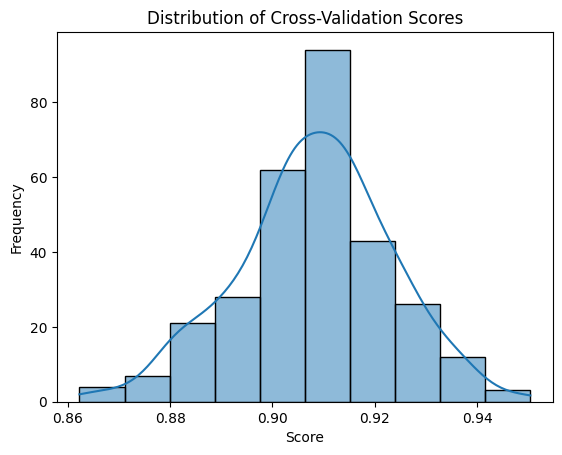

In [5]:
logistic_regression_model = LogisticRegression()

logistic_regression_model.fit(x_train, y_train)

print("Logistic Regression Score (single run): ", logistic_regression_model.score(x_test, y_test))

# find proportion in test set to use as baseline
class_proportions = y_test.value_counts(normalize=True)
baseline_accuracy = class_proportions.max()
print("Baseline Accuracy:", baseline_accuracy)

rkf = RepeatedKFold(n_splits=10, n_repeats=30, random_state=42)

logistic_regression_scores = cross_val_score(logistic_regression_model, x, y, cv=rkf, scoring='accuracy')

mean_score = np.mean(logistic_regression_scores)
std_score = np.std(logistic_regression_scores)
confidence_interval = np.percentile(logistic_regression_scores, [2.5, 97.5])

print("Mean Cross-Validation Score:", mean_score)
print("Standard Deviation:", std_score)
print('95% Confidence Interval:', confidence_interval[0], "-", confidence_interval[1])

sns.histplot(logistic_regression_scores, kde=True, bins=10)
plt.title('Distribution of Cross-Validation Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

### Model Selection (Testing Random Forest Classifier)

Random Forest Classifier Score (single run): 0.9017447199265382
Mean Cross-Validation Score: 0.9069972451790634
Standard Deviation: 0.015010378635598898
95% Confidence Interval: 0.8773415977961432 - 0.9366391184573003


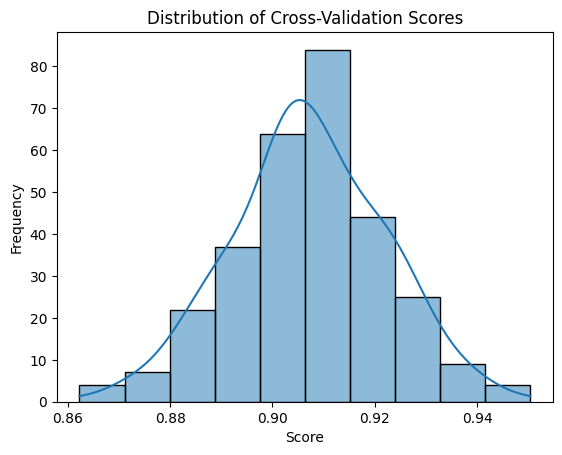

In [6]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(x_train, y_train)

print("Random Forest Classifier Score (single run):", random_forest_model.score(x_test, y_test))

rkf = RepeatedKFold(n_splits=10, n_repeats=30, random_state=42)

random_forest_scores = cross_val_score(random_forest_model, x, y, cv=rkf, scoring='accuracy')

mean_score = np.mean(random_forest_scores)
std_score = np.std(random_forest_scores)
confidence_interval = np.percentile(random_forest_scores, [2.5, 97.5])

print("Mean Cross-Validation Score:", mean_score)
print("Standard Deviation:", std_score)
print('95% Confidence Interval:', confidence_interval[0], "-", confidence_interval[1])


sns.histplot(random_forest_scores, kde=True, bins=10)
plt.title('Distribution of Cross-Validation Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

### Model Selection (Testing Decision Tree Classifier)

Decision Tree Classifier Score (single run): 0.8530762167125804
Mean Cross-Validation Score: 0.8549127640036731
Standard Deviation: 0.01862081448027413
95% Confidence Interval: 0.8181818181818182 - 0.8870523415977961


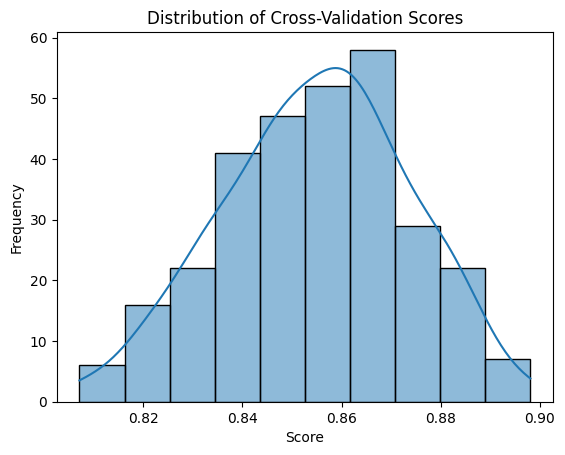

In [7]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(x_train, y_train)

print("Decision Tree Classifier Score (single run):", decision_tree_model.score(x_test, y_test))

rkf = RepeatedKFold(n_splits=10, n_repeats=30, random_state=42)

decision_tree_scores = cross_val_score(decision_tree_model, x, y, cv=rkf, scoring='accuracy')

mean_score = np.mean(decision_tree_scores)
std_score = np.std(decision_tree_scores)
confidence_interval = np.percentile(decision_tree_scores, [2.5, 97.5])

print("Mean Cross-Validation Score:", mean_score)
print("Standard Deviation:", std_score)
print('95% Confidence Interval:', confidence_interval[0], "-", confidence_interval[1])


sns.histplot(decision_tree_scores, kde=True, bins=10)
plt.title('Distribution of Cross-Validation Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

### Model Selection (Testing Support Vector Machine)

Support Vector Machine Score (single run): 0.8319559228650137
Mean Cross-Validation Score: 0.845068870523416
Standard Deviation: 0.01862081448027413
95% Confidence Interval: 0.8071625344352618 - 0.8884986225895316


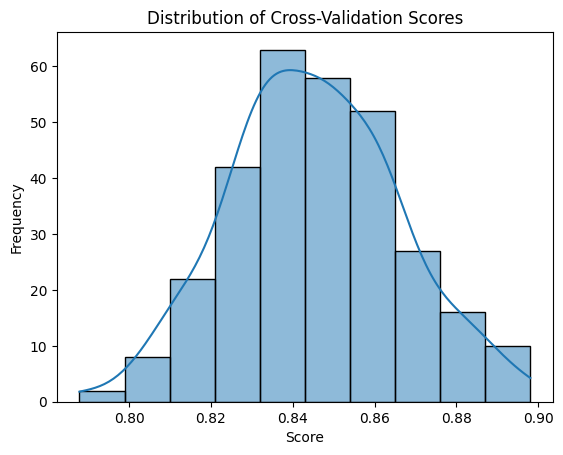

In [8]:
svm_model = svm.SVC()
svm_model.fit(x_train, y_train)

print("Support Vector Machine Score (single run):", svm_model.score(x_test, y_test))

rkf = RepeatedKFold(n_splits=10, n_repeats=30, random_state=42)

svm_scores = cross_val_score(svm_model, x, y, cv=rkf, scoring='accuracy')

mean_score = np.mean(svm_scores)
std_score = np.std(decision_tree_scores)
confidence_interval = np.percentile(svm_scores, [2.5, 97.5])

print("Mean Cross-Validation Score:", mean_score)
print("Standard Deviation:", std_score)
print('95% Confidence Interval:', confidence_interval[0], "-", confidence_interval[1])


sns.histplot(svm_scores, kde=True, bins=10)
plt.title('Distribution of Cross-Validation Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

### Model Analysis

In [9]:
# dropping the categorical columns. They don't have a significant impact on the model's performance and make analysis more difficult because they have to be one hot encoded for logistical regression
drop_columns = ['Application mode', 'Marital status', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", "Nacionality", "Previous qualification", "Previous qualification (grade)", "Target"]

prepared_df_no_categorical = df.drop(columns=drop_columns)

x_train_no_categorical, x_test_no_categorical, y_train_no_categorical, y_test_no_categorical = train_test_split(prepared_df_no_categorical, y, test_size=0.3, random_state=42)

x_train_const = sm.add_constant(x_train_no_categorical)

# removing changing the type of bool columns because they cause issues with the model
bool_cols = x_train_const.select_dtypes(include=['bool']).columns
x_train_const[bool_cols] = x_train_const[bool_cols].astype(int)

# I'm not sure if we're doing this part or not yet
'''
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Calculate VIF for each variable
vif_data = calculate_vif(x_train_const)
print(vif_data[vif_data['VIF'] > 10])
'''

model_sm_no_categorical = sm.Logit(y_train_no_categorical, x_train_const).fit()

# measure accuracy
predictions = model_sm_no_categorical.predict(sm.add_constant(x_test_no_categorical))
predictions_binary = np.round(predictions)

accuracy = np.mean(predictions_binary == y_test_no_categorical)

print("Mean Accuracy:", accuracy)
print(model_sm_no_categorical.summary())


Optimization terminated successfully.
         Current function value: 0.234760
         Iterations 9
Mean Accuracy: 0.9127640036730946
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                 2541
Model:                          Logit   Df Residuals:                     2513
Method:                           MLE   Df Model:                           27
Date:                Sun, 22 Oct 2023   Pseudo R-squ.:                  0.6504
Time:                        12:28:09   Log-Likelihood:                -596.53
converged:                       True   LL-Null:                       -1706.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
co